<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classifying Reddit Posts from Trump and Biden Subreddits using NLP Classification

--- 
# Part 2: Preprocessing, modeling
---

### Overview of this notebook

We start by preprocessing our dataset, removing unwanted strings and binarizing our target feature.\
We follow with 2 different strategies, the first is to remove words in an attempt to reduce overfitting, the next is to tune the hyperparameters.\
We find that the first stetegy for this dataset works better.

### Contents:
- [Data Dictionary](#Data-Dictionary)
- [Preprocessing](#Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
- [New Strategy](#New-Strategy!)
- [Summary](#Summary)
- [Conclusions](#Conclusions)

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|subreddit|int|0,1 values, 0 if Biden, 1 if Trump|
|selftext|object|Reddit poster's body text|
|title|object|Reddit poster's title text|
|combined|object|Reddit poster's selftext+title|

## Preprocessing

In [1]:
#imports
#Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Preprocessing
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer   
# from nltk.corpus import stopwords

#Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
df = pd.read_csv('../data/trump-biden-reddit-scape.csv')

In [3]:
df.head()

,subreddit,selftext,title,combined
0,trump,NaN,GOP Gov Doesn’t Let NBC’s Chuck Todd Get Away ...,GOP Gov Doesn’t Let NBC’s Chuck Todd Get Away...
1,trump,NaN,Pence says ‘history will hold Donald Trump acc...,Pence says ‘history will hold Donald Trump ac...
2,trump,NaN,WATCH: Video of Suitcases of Ballots in GA Ele...,WATCH: Video of Suitcases of Ballots in GA El...
3,trump,NaN,"WATCH: Schumer Threatens Fox, Says He Has ‘Rig...","WATCH: Schumer Threatens Fox, Says He Has ‘Ri..."
4,trump,NaN,12 Hours Free Election Integrity Education and...,12 Hours Free Election Integrity Education an...


Seeing as how the feature `combined` is a concatenation of `selftext` and `title`, we proceed to drop those 2 features.

In [4]:
df = df.drop(columns = ['selftext', 'title'])

In [5]:
df.isnull().sum()

subreddit    0
combined     0
dtype: int64

In [6]:
df['subreddit'].unique()

array(['trump', 'JoeBiden'], dtype=object)

Trump = 1, Biden = 0

In [7]:
df['subreddit'] = df['subreddit'].map({'trump': 1, 'JoeBiden': 0})

In [8]:
df.head()

,subreddit,combined
0,1,GOP Gov Doesn’t Let NBC’s Chuck Todd Get Away...
1,1,Pence says ‘history will hold Donald Trump ac...
2,1,WATCH: Video of Suitcases of Ballots in GA El...
3,1,"WATCH: Schumer Threatens Fox, Says He Has ‘Ri..."
4,1,12 Hours Free Election Integrity Education an...


Printing the strings for a quick scan of what type of cleaning we would have to do.\
For example, we would not want html/urls/emails as they usually do not carry much meaning.

In [9]:
for string in df['combined']:
    print(string)

 GOP Gov Doesn’t Let NBC’s Chuck Todd Get Away With These Remarks About Media Credibility
 Pence says ‘history will hold Donald Trump accountable’ for Jan. 6th
 WATCH: Video of Suitcases of Ballots in GA Election Hearing 2020 Elections
 WATCH: Schumer Threatens Fox, Says He Has ‘Right’ To Tell Them ‘What to Do’
 12 Hours Free Election Integrity Education and Training Marathon March 12, 2023 at 9 AM
 Perth Mint Sold Billions in Diluted Gold to China, Tried To Cover It Up
 You want this joke of a man to run your country?? Biden is bad, but Trump is a piece of shit that this country does not need.
 Trump, Biden &amp; DeSantis, CBDC, Joke of the Week, Stand In God and Truth and Fear Not
 Trump, Biden &amp; DeSantis, CBDC, Joke of the Week, Stand In God and Truth and Fear Not https://open.spotify.com/episode/6xhqlr9ZOAjHkZjgbZGjii?si=ab835239bd824d1b
 Keith Olbermann Melts Down and Tries to Get Twitter CEO Elon Musk Banned from His Personal Platform – Musk Responds in Epic Style
 Comedian S

**END OF PRINT**

Notice that we have many urls and emoticons and some noise such as `&amp;#x200B;`. It does not look like we have any emails/html or linebreaks etc.\
We will also have to remove words such as donald, trump, joe, and biden for obvious reasons.\
We will attempt to remove all of the above by running the data through the `preprocessing_worker` function.

In [10]:
def preprocessing_worker(string):   
    
    #Cleaning
    string = BeautifulSoup(string, 'html.parser').get_text() #html
    string = re.sub(r'http\S+', '', string) #urls
    string = re.sub(r'www\S+', '', string) #urls
    string = re.sub(r'\S+@\S+', '', string) #email
    string = string.replace('-', ' ')
    string = re.sub(r'[^\w\s,]', '', string) #emoticons
    string = re.sub("&amp;#x200B;", "", string) #&amp;#x200B;
    string = re.sub(r'[^a-zA-Z]', ' ', string).lower()
    string = re.sub(r'\b\w{1}\b', '', string) #single letters

    #Tokenize
    tokens = word_tokenize(string)

    #Remove stopwords
    tokens = [token for token in tokens if token not in set(CountVectorizer(stop_words='english').get_stop_words())]
    tokens = [token for token in tokens if token not in set(['donald', 'trump', 'trumps', 'joe', 'biden', 'bidens'])]

    #Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [11]:
df['combined'] = df['combined'].apply(preprocessing_worker)

C:\Users\samue\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [12]:
for string in df['combined']:
    print(string)

gop gov doesnt let nbcs chuck todd away remark medium credibility
penny say history hold accountable jan th
watch video suitcase ballot ga election hearing election
watch schumer threatens fox say right tell
hour free election integrity education training marathon march
perth mint sold billion diluted gold china tried cover
want joke man run country bad piece shit country doe need
desantis cbdc joke week stand god truth fear
desantis cbdc joke week stand god truth fear
keith olbermann melt try twitter ceo elon musk banned personal platform musk responds epic style
comedian sue aoc blocking twitter cite court ruling barred blocking people
obama state department official richard stengel belief ok push propaganda american did head corrupt gec
need violent insurrection hearing year
level destruction
here elise stefanik turned fbi director stammering mess
silicon valley bank collapse percent deposit insured regulator shut silicon valley bank today following run deposit
based chinese scienti

**END OF PRINT**

A quick scroll shows that we have gotten rid of all the above words.

In [13]:
df.shape

(1979, 2)

In [14]:
df = df.drop_duplicates()

In [15]:
df.shape

(1963, 2)

In [16]:
df.to_csv('../data/trump-biden-reddit-clean.csv', index = False)

We now have a clean dataset.

[Back to top](#Contents:)

## Exploratory Data Analysis

We use `CountVectorizer` to check our top words. 

In [17]:
def word_count(df, num=50):
    cv = CountVectorizer(ngram_range=(1,3))
    X_df = cv.fit_transform(df['combined'])
    X_plot = pd.DataFrame(X_df.todense(), 
                                columns=cv.get_feature_names_out())
    return X_plot.sum().sort_values(ascending=False).head(num)

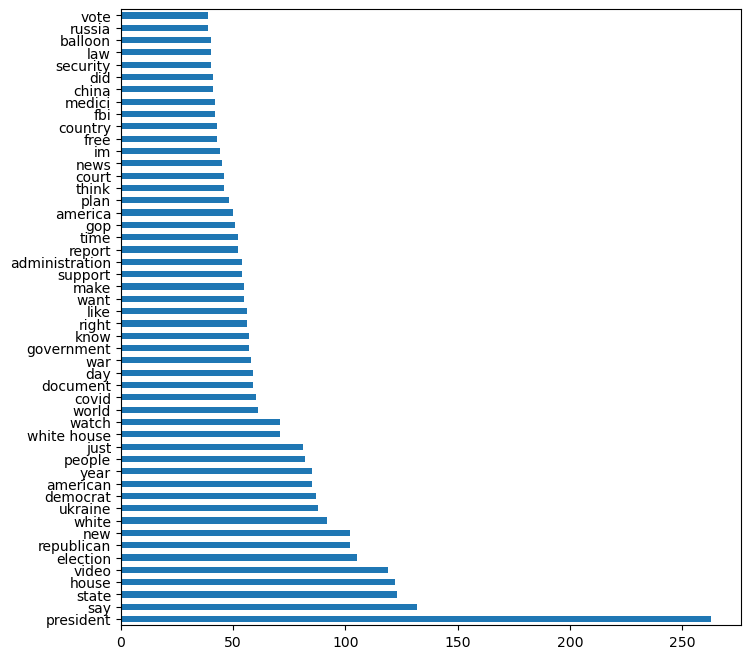

In [18]:
plt.figure(figsize=(8,8))
word_count(df).plot(kind='barh');

[Back to top](#Contents:)

## Modeling

In [19]:
def train_test_worker(test = 0.25):
    X_train, X_test, y_train, y_test = train_test_split(df['combined'], df['subreddit'], test_size=test, random_state=42, stratify=df['subreddit'])
    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = train_test_worker()

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1472,), (1472,), (491,), (491,))

### Baseline Accuracy

In [22]:
y_test.value_counts(normalize=True)

1    0.562118
0    0.437882
Name: subreddit, dtype: float64

### Modeling worker

This function will return the transformer, estimator and parameters that give the best CV score.

In [23]:
#Universal arguments
#DEFAULTS, FEEL FREE TO DEFINE YOUR OWN ARGUMENTS IN A DIFFERENT CELL
estimators = {'nb': ('nb', MultinomialNB()), 'lr': ('lr', LogisticRegression())}
transformers = {'cvec': ('cvec', CountVectorizer()), 'tvec': ('tvec', TfidfVectorizer())}
transformer_params = {
    'cvec': {  
        'cvec__max_features': [3_000, 4_000, 5_000, 6_000],
        'cvec__min_df': [1, 2, 3, 4, 5],
        'cvec__max_df': np.linspace(0.7,1,5),
        'cvec__ngram_range': [(1,1), (1,2), (1,3)]
    },
    
    'tvec': {
        'tvec__max_features': [3_000, 4_000, 5_000, 6_000],
        'tvec__min_df': [1, 2, 3, 4, 5],
        'tvec__max_df': np.linspace(0.7,1,5),
        'tvec__ngram_range': [(1,1), (1,2), (1,3)]
    }
}

estimator_params = {
    'nb': {
        'nb__alpha': [1,2,3,4,5]
    },
    
    'lr': {
        'lr__solver': ['liblinear'],
        'lr__penalty': ['l2'],
        'lr__C': np.linspace(0.2, 1, 6)
    }
}

In [24]:
#returns the model with the least difference in train vs test scores.
def modeling_worker(estimators, 
                    transformers, 
                    transformer_params, 
                    estimator_params, 
                    typ = 'diff' #criterion: can choose to return model with best test scores, or best train scores or default
                   ):
    
    dictionary = dict()
    for transformer in transformers:
        for estimator in estimators:
            print(f'Testing for {transformer} x {estimator}')
            pipe = Pipeline([
                transformers[transformer],
                estimators[estimator]
            ])
            params = {
                **transformer_params[transformer],
                **estimator_params[estimator]
            }
            gs = GridSearchCV(pipe,
                             param_grid=params,
                             cv=5,
                             n_jobs=-1)
            gs.fit(X_train, y_train)
            
            typ_selector = {'diff': gs.score(X_train, y_train)-gs.score(X_test, y_test), 'train': gs.score(X_train, y_train), 'test': gs.score(X_test, y_test)}
            
            dictionary[typ_selector[typ]] = (transformer, estimator, gs.best_params_, gs.best_score_, gs.score(X_train, y_train), gs.score(X_test, y_test))
            
            print('Done!')
    return dictionary[min(dictionary)]

### First modeling iteration

[back to bottom](#back)

In [25]:
# %%time
# tup = modeling_worker(estimators, transformers, transformer_params, estimator_params)

# The following are the output of running the above worker.
tup = ('tvec',
 'lr',
 {'lr__C': 1.0,
  'lr__penalty': 'l2',
  'lr__solver': 'liblinear',
  'tvec__max_df': 0.7,
  'tvec__max_features': 3000,
  'tvec__min_df': 2,
  'tvec__ngram_range': (1, 1)},
 0.7567900380491179, #best
 0.9157608695652174, #train
 0.790224032586558)  #test

There seems to be significant overfitting! In an attempt to reduce noice, we will try removing stopwords that both occur often and has significant impact (coefficient) on our model.\
Note that while `cvec__max_df` is at the boundary, we ignore it for now in order to check for words that are noise.

In [26]:
def fitting_worker(estimators, transformers, tupperware):
    pipe = Pipeline([
        transformers[tupperware[0]],
        estimators[tupperware[1]]
    ])
    params = tupperware[2]
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    return pipe

Let's compare the words with the highest coefficients against our top 25 words found above.

In [27]:
def coefficients(pipe, tupperware):
    estimator = pipe.named_steps[tupperware[1]]
    feature_names = pipe.named_steps[tupperware[0]].get_feature_names_out()
    
    if tupperware[1] == 'nb':
        coefficients_df = pd.DataFrame({'feature_name': feature_names, 'coefficient': estimator.feature_log_prob_[1]-estimator.feature_log_prob_[0]})
    
    else:
        coefficients_df = pd.DataFrame({'feature_name': feature_names, 'coefficient': estimator.coef_[0]})
        
    return coefficients_df.sort_values(by='coefficient', ascending=False)

In [28]:
pipe = fitting_worker(estimators, transformers, tup)
sorted_coefficients = coefficients(pipe,tup)

In [29]:
sorted_coefficients.head(25)

,feature_name,coefficient
487,covid,1.307774
1006,hunter,1.296712
440,conservative,1.286011
2221,tucker,1.245308
1331,medium,1.241109
1329,medici,1.192335
466,corrupt,1.142249
2359,woke,1.136958
770,fbi,1.065435
2279,video,1.064956


In [30]:
sorted_coefficients.tail(25)

,feature_name,coefficient
64,aid,-0.967425
1486,opinion,-0.989341
2343,white,-1.014403
2351,win,-1.058109
1681,putin,-1.063464
434,congress,-1.074817
1115,job,-1.077163
290,campaign,-1.081327
2367,worker,-1.086832
215,bipartisan,-1.109974


The above are the top 25 predictors for each subreddit, negative being predictive for Biden's reddit and positive for Trump's reddit. We will compare this list with our 50 words from the function `word_count`. We will drop those words from `X_plot` that are NOT in either of the 2 top 25 predictors.

In [31]:
more_stop_words = [word for word in word_count(df, num = 50).index if word not in list(sorted_coefficients.head(25)['feature_name']) and word not in list(sorted_coefficients.tail(25)['feature_name'])]
more_stop_words, len(more_stop_words)

(['say',
  'state',
  'election',
  'new',
  'ukraine',
  'american',
  'people',
  'just',
  'white house',
  'world',
  'document',
  'day',
  'war',
  'government',
  'know',
  'right',
  'like',
  'want',
  'make',
  'support',
  'time',
  'gop',
  'america',
  'plan',
  'think',
  'court',
  'news',
  'im',
  'free',
  'country',
  'china',
  'did',
  'security',
  'law',
  'russia',
  'vote'],
 36)

In [32]:
def remove_more_words(words):
    tokens = word_tokenize(words)
    tokens = [token for token in tokens if token not in set(more_stop_words)]
    return ' '.join(tokens)

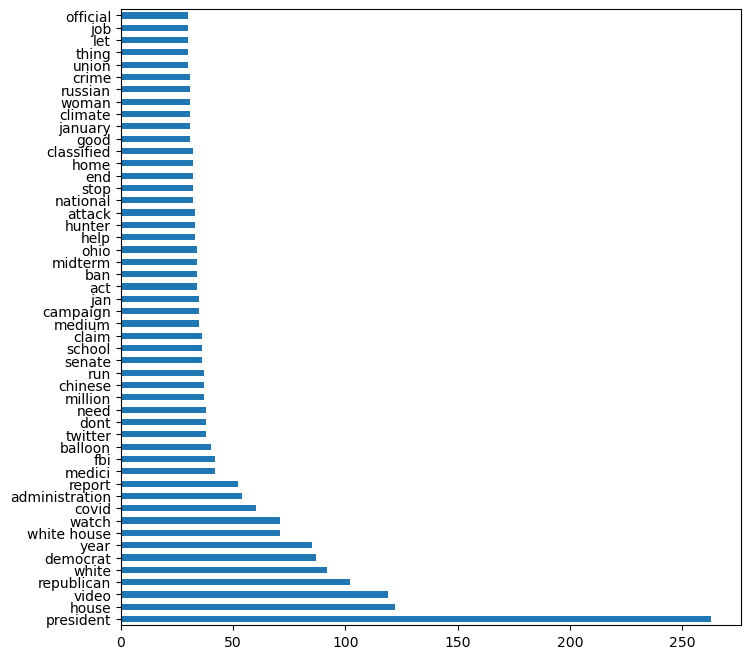

In [33]:
df['combined'] = df['combined'].apply(remove_more_words)

plt.figure(figsize=(8,8))
word_count(df).plot(kind='barh');

Notice that those words have been removed. We now do our 2nd iteration of the modeling process!

### Second modeling iteration

In [34]:
X_train, X_test, y_train, y_test = train_test_worker()

In [35]:
# %%time
# tup_2 = modeling_worker(estimators, transformers, transformer_params, estimator_params)

# same as above
tup_2 = ('tvec',
 'lr',
 {'lr__C': 1.0,
  'lr__penalty': 'l2',
  'lr__solver': 'liblinear',
  'tvec__max_df': 0.7,
  'tvec__max_features': 4000,
  'tvec__min_df': 1,
  'tvec__ngram_range': (1, 3)},
 0.7642638072178023,
 0.9307065217391305,
 0.7861507128309573)

#Wall time: 6min 33s

We once again see that for `cvec__max_df`are hitting the bound. We again fit the model to check the importance of each word.

In [36]:
pipe_2 = fitting_worker(estimators, transformers, tup_2)
sorted_coefficients = coefficients(pipe_2,tup_2)

In [37]:
print(sorted_coefficients.head(25))

       feature_name  coefficient
673           covid     1.267299
1456         hunter     1.232439
1923         medium     1.228000
611    conservative     1.171877
3722          video     1.155172
3779          watch     1.138573
3624         tucker     1.112721
647         corrupt     1.101589
3939           woke     1.064247
2920           real     1.030943
1088            fbi     1.012923
489           child     0.937099
2993         report     0.929282
815        desantis     0.912032
1908         medici     0.880573
1373        hearing     0.879519
1553  investigation     0.866040
664          county     0.846520
3027        reveals     0.817210
1763            lie     0.816068
229            away     0.784371
1354           hate     0.783180
3831            wef     0.776943
3768        warning     0.771967
239         balloon     0.766270


In [38]:
print(sorted_coefficients.tail(25))

        feature_name  coefficient
88               aid    -0.923606
2177         opinion    -0.929073
3956          worker    -0.992816
399         campaign    -0.993791
605         congress    -0.994520
293       bipartisan    -1.036161
1604             job    -1.048971
793         democrat    -1.053536
2874           putin    -1.061997
3930             win    -1.121341
3915     white house    -1.127272
3981            year    -1.149220
1904        medicare    -1.159026
754             debt    -1.198984
1599            jill    -1.238722
3185          senate    -1.276170
1434           house    -1.302336
1782            live    -1.333287
801       democratic    -1.335424
951          economy    -1.338994
3674           union    -1.456752
1967         midterm    -1.477989
45    administration    -1.587333
2999      republican    -2.105995
2665       president    -2.238303


In [39]:
more_stop_words = [word for word in word_count(df, num = 50).index if word not in list(sorted_coefficients.head(25)['feature_name']) and list(sorted_coefficients.tail(25)['feature_name'])]
print(more_stop_words, len(more_stop_words))

['president', 'house', 'republican', 'white', 'democrat', 'year', 'white house', 'administration', 'twitter', 'dont', 'need', 'million', 'chinese', 'run', 'senate', 'school', 'claim', 'campaign', 'jan', 'act', 'ban', 'midterm', 'ohio', 'help', 'attack', 'national', 'stop', 'end', 'home', 'classified', 'good', 'january', 'climate', 'woman', 'russian', 'crime', 'union', 'thing', 'let', 'job', 'official'] 41


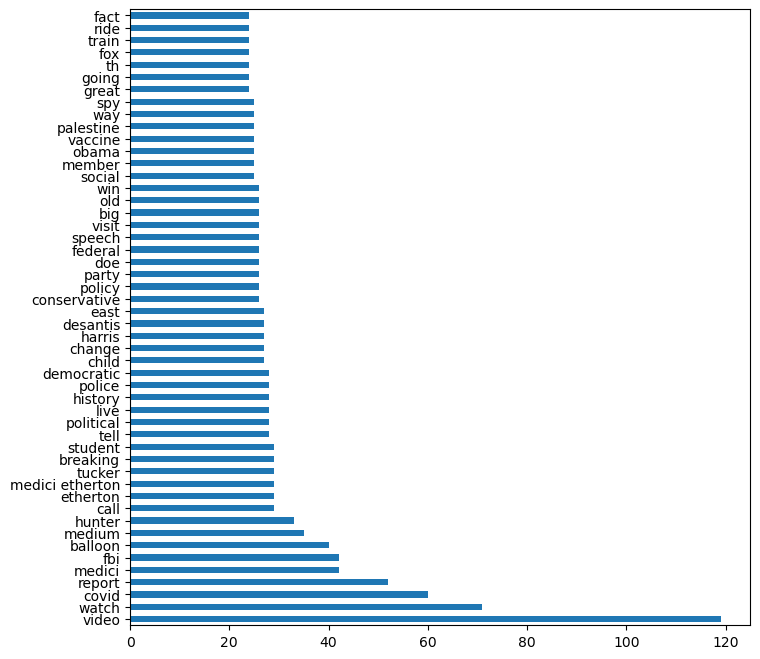

In [40]:
df['combined'] = df['combined'].apply(remove_more_words)
plt.figure(figsize=(8,8))
word_count(df).plot(kind='barh');

### Third modeling iteration

In [41]:
X_train, X_test, y_train, y_test = train_test_worker()

In [42]:
# %%time
# tup_3 = modeling_worker(estimators, transformers, transformer_params, estimator_params)

#same as above
tup_3 = ('cvec',
 'nb',
 {'cvec__max_df': 0.7,
  'cvec__max_features': 5000,
  'cvec__min_df': 1,
  'cvec__ngram_range': (1, 2),
  'nb__alpha': 1},
 0.760196010607633,
 0.9402173913043478,
 0.7596741344195519)

#Wall time: 5min 55s

In [43]:
pipe_3 = fitting_worker(estimators, transformers, tup_3)
sorted_coefficients = coefficients(pipe_3,tup_3)

In [44]:
sorted_coefficients.head(25)

,feature_name,coefficient
1668,medici,3.362812
878,etherton,2.957347
4771,tucker,2.957347
1670,medici etherton,2.957347
4954,woke,2.643690
436,child,2.589622
1176,hate,2.407301
3529,public,2.338308
4833,vaccine,2.338308
3633,queen gena,2.338308


In [45]:
sorted_coefficients.tail(25)

,feature_name,coefficient
1455,labor,-2.246659
4964,worker,-2.246659
240,benefit,-2.246659
661,debt ceiling,-2.246659
325,btrtn,-2.246659
327,budget,-2.246659
3096,poland,-2.246659
4374,sen,-2.380191
4469,social medicare,-2.380191
117,anniversary,-2.380191


In [46]:
more_stop_words = [word for word in word_count(df, num = 50).index if word not in list(sorted_coefficients.head(25)['feature_name']) and list(sorted_coefficients.tail(25)['feature_name'])]
print(more_stop_words, len(more_stop_words))

['video', 'watch', 'covid', 'report', 'fbi', 'balloon', 'medium', 'hunter', 'call', 'breaking', 'student', 'tell', 'political', 'live', 'history', 'police', 'democratic', 'change', 'harris', 'desantis', 'east', 'conservative', 'policy', 'party', 'doe', 'federal', 'speech', 'visit', 'big', 'old', 'win', 'social', 'member', 'obama', 'palestine', 'way', 'spy', 'great', 'going', 'th', 'fox', 'train', 'ride', 'fact'] 44


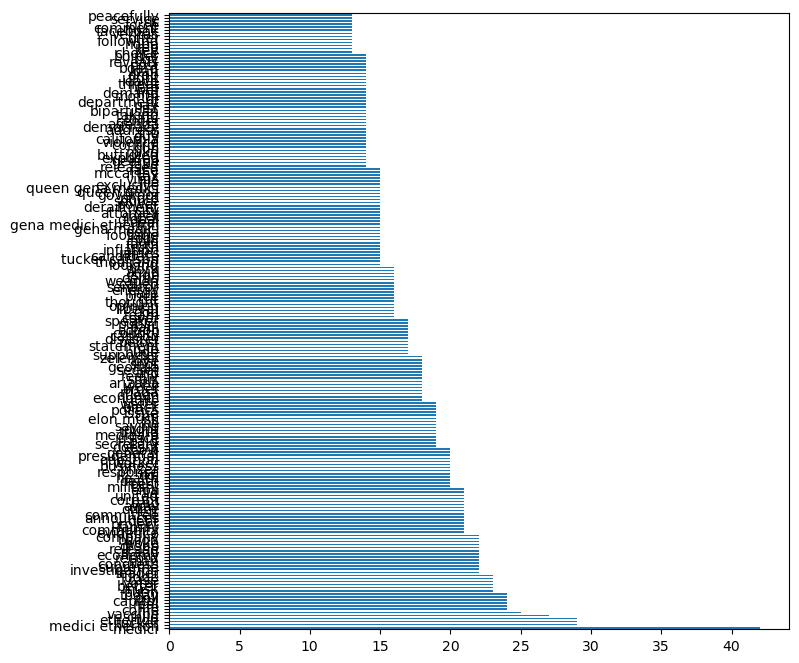

In [47]:
df['combined'] = df['combined'].apply(remove_more_words)
plt.figure(figsize=(8,8))
word_count(df,num=200).plot(kind='barh');

**#bestplotever**

### Fourth model iteration (with `GradientBoost` and `AdaBoost`)

In [48]:
# new stuff learnt in class
estimators['gb'] = ('gb', GradientBoostingClassifier(random_state=42))
estimators['ada'] = ('ada', AdaBoostClassifier(random_state=42))

estimator_params['gb'] = {
    'gb__max_depth': [2,3,4],
    'gb__n_estimators': [100, 125, 150],
    'gb__learning_rate': [.08, .1, .12]
}

estimator_params['ada'] = {
    'ada__n_estimators': [50,100],
    'ada__learning_rate': [.9, 1.]
}

In [49]:
# %%time
# tup_4 = modeling_worker(estimators, transformers, transformer_params, estimator_params)

# Same as above
tup_4 = ('cvec',
 'ada',
 {'ada__learning_rate': 0.9,
  'ada__n_estimators': 100,
  'cvec__max_df': 0.7,
  'cvec__max_features': 3000,
  'cvec__min_df': 5,
  'cvec__ngram_range': (1, 2)},
 0.6351712210307853,
 0.7445652173913043,
 0.6028513238289206)

#Wall time: 1h 29min 22s

It seems that our score has been progessively becoming worse. We will scrape this method of dropping words.\
Instead, our strategy now would be to attempt to first compare between 3 estimators, `'nb'`, `'lr'` and `'ada'` and tune the best model.

[Back](#Contents:)

## New Strategy!

In [50]:
#Import fresh copy of df
df = pd.read_csv('../data/trump-biden-reddit-clean.csv').dropna().reset_index()
df.head()

,index,subreddit,combined
0,0,1,gop gov doesnt let nbcs chuck todd away remark...
1,1,1,penny say history hold accountable jan th
2,2,1,watch video suitcase ballot ga election hearin...
3,3,1,watch schumer threatens fox say right tell
4,4,1,hour free election integrity education trainin...


In [51]:
df.shape

(1961, 3)

### Compare different models

In [52]:
estimators = {'nb': ('nb', MultinomialNB()), 'lr': ('lr', LogisticRegression())}
transformers = {'cvec': ('cvec', CountVectorizer()), 'tvec': ('tvec', TfidfVectorizer())}
transformer_params = {
    'cvec': {  
        'cvec__max_features': [3_000, 4_000, 5_000, 6_000],
        'cvec__min_df': [1, 2, 3, 4, 5],
        'cvec__max_df': np.linspace(0.7,1,5),
        'cvec__ngram_range': [(1,1), (1,2), (1,3)]
    },
    
    'tvec': {
        'tvec__max_features': [3_000, 4_000, 5_000, 6_000],
        'tvec__min_df': [1, 2, 3, 4, 5],
        'tvec__max_df': np.linspace(0.7,1,5),
        'tvec__ngram_range': [(1,1), (1,2), (1,3)]
    }
}

estimator_params = {
    'nb': {
        'nb__alpha': [1,2,3,4,5]
    },
    
    'lr': {
        'lr__solver': ['liblinear'],
        'lr__penalty': ['l2'],
        'lr__C': np.linspace(0.2, 1, 6)
    }
}

estimator_params['ada'] = {
    'ada__n_estimators': [50,100],
    'ada__learning_rate': [.9, 1.]
}

estimators['ada'] = ('ada', AdaBoostClassifier(random_state=42))

In [53]:
# %%time
# tup = modeling_worker(estimators, transformers, transformer_params, estimator_params)
tup = ('cvec',
 'ada',
 {'ada__learning_rate': 1.0,
  'ada__n_estimators': 100,
  'cvec__max_df': 0.7,
  'cvec__max_features': 3000,
  'cvec__min_df': 5,
  'cvec__ngram_range': (1, 1)},
 0.7061224489795919,
 0.8013605442176871,
 0.714867617107943)

#Wall time: 19min 37s

<a id='runnerup'></a>We will now attempt to focus all our efforts into `'ada'` and `'cvec'`.\
Recall, our parameters were:\
`'ada__learning_rate': [.9, 1.]`\
`'ada__n_estimators': [50,100]`\
`'cvec__max_df': np.linspace(0.7,1,5)`\
`'cvec__max_features': [3_000, 4_000, 5_000, 6_000]`\
`'cvec__min_df': [1, 2, 3, 4, 5]`\
`'cvec__ngram_range': [(1,1), (1,2), (1,3)]`\
of which, all the `cvec` parameters in the model above are all at the boundary. We will try to tune them in the direction of their boundary.

[back to summary](#compare)

### Tweaking parameters for (`'cvec'`, `'ada'`)

In [54]:
#returns the model with the least difference in train vs test scores.
def modeling_worker_2(params):

    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))
    ])
    
    gs = GridSearchCV(pipe,
                     param_grid=params,
                     cv=5,
                     n_jobs=-1)
    gs.fit(X_train, y_train)
    
    return gs

In [55]:
X_train, X_test, y_train, y_test = train_test_worker()

In [56]:
params = {
    'cvec__max_features': [2_500, 3_000,3_500],
    'cvec__min_df': [5,6,7],
    'cvec__max_df': np.linspace(0.5,0.7,3),
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ada__learning_rate': np.linspace(1, 2, 3),
    'ada__n_estimators': [100, 150, 200],
    'ada__base_estimator__max_depth': [2,3,4],
    'ada__base_estimator__min_samples_split': [2,3,5],
    'ada__base_estimator__splitter': ['best', 'random']
}

In [57]:
# %%time
# tup = modeling_worker_2(params)
#Wall time: 1h 3min 7s

<a id='back'></a>Based on the parameters we have used to run `tup = modeling_worker_2`, notice our model has became alot more overfitted. We will instead choose to use the model we found [above](#First-modeling-iteration) in the previous section.

`'best_params_'` = {`'ada__base_estimator__max_depth': 2`,\
  `'ada__base_estimator__max_features': 'auto'`,\
  `'ada__base_estimator__min_samples_split': 3`,\
  `'ada__base_estimator__splitter': 'best'`,\
  `'ada__learning_rate': 1.5`,\
  `'ada__n_estimators': 200`,\
  `'cvec__max_df': 0.5`,\
  `'cvec__max_features': 2500`,\
  `'cvec__min_df': 5`,\
  `'cvec__ngram_range': (1, 1)}`,\
`Train score` = `0.9605442176870749`,\
`Test score` = `0.6863543788187373`

[Back](#Contents:)

## Summary

The model that we will be choosing is the model with:
- `transformer:'tvec'`,
- `estimator: 'lr'`,\
and parameters:
- `'lr__C': 1.0`,
- `'lr__penalty': 'l2'`,
- `'lr__solver': 'liblinear'`,
- `'tvec__max_df': 0.7,`
- `'tvec__max_features': 3000`,
- `'tvec__min_df': 2`,
- `'tvec__ngram_range': (1, 1)`,\
with scores:
- `Train: 0.91`
- `Test: 0.79`

This is based on the model with no extra words removed.\
<a id='compare'></a>We have chose this model out of the rest for two reasons, first and more importantly is that it has a relatively lower (not the lowest!) amount of overfitting as compared to the other models while still having a relatively high train score. In contrast with our [runner up model](#runnerup) which has scores: `'train': 0.80`, `'test': 0.71`.\
The difference between the train and test scores for the first and second models are 12% and 9% respectively, but the first model has higher scores overall. In this case, we are accepting the higher overfitting in favour of better performance.

The most frequently occuring words are:

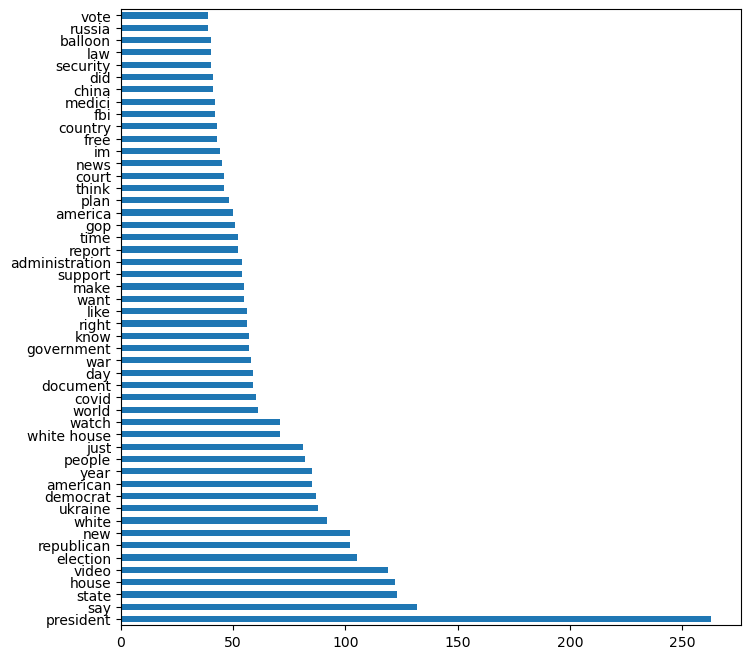

In [58]:
plt.figure(figsize=(8,8))
word_count(df).plot(kind='barh');

The top 5 words predicting in favour of being in Trump's reddit are:
|feature_name|coefficient|
|---|---|
|covid|1.307774|
|hunter|1.296712|
|conservative|1.286011|
|tucker|1.245308|
|medium|1.241109|

While the top 5 words predicting in favour of being in Biden's reddit are:
|feature_name|coefficient|
|---|---|
|union|-1.456752|
|midterm|-1.477989|
|administration|-1.587333|
|republican|-2.105995|
|president|-2.238303|

[Back](#Contents:)

## Conclusions

For the specific subreddits we scrapped, we ran into problems with overfitting of the train data. We have tried 3 methods (1 of them is not shown) to deal with the overfitting problem. We started by reducing the criterion (number of characters) from 80 to 60 for `title` to be deemed to "contain" enough words to be substituted/added to `selftext`. This helped to increase the number of documents we have by close to double, it did little to reduce overfitting though.

Next, we tried to remove words that occur frequently but do not have high coefficients. That is, we have specified those words as noise and have tried to remove them. Our attempts did not seem to be too successful as both the train and test scores were dropping with the overfitting problem not improving.\
On hindsight, our method for selecting the words to remove seems too rudimentary, where we only considered if the words occur with high frequency and if they are in the top 50 words with large coefficients. We could instead have specified that for some limiting frequency f, and some limiting coefficient c, if frequency of of word > f and coefficient of word < c, then we drop that word.

Lastly, we used `modeling_worker` to "guess" which combination of estimator and transformer would give a good score that is also not overfitted. We then proceeded to tune that particular combination in an attempt to produce a good model. It turns out, either we were tuning the model in the wrong way, or using such a method to choose which combination to use is equivalent to trying to predict the lottery. 

At the end of all the methods that we have attempted, we find that the model produced in the very first iteration is the "best", not in terms of least underfitting but taking into account the trade off between being overfitted but still being able to predict well.

To conclude, we will talk about the top words and their coefficients. In particular, for the method where we were removing words, by the third iteration, it seems that the coefficients for the words became very significant, but recall that the scores have also dropped as well, meaning that even though the words are very significant, they are only able to explain a smaller part of the variance as compared to if we had more words. I.e., it is not very helpful to talk about the coefficients of a word if the model score was very low in the first place. 

### Future Work

In an extension of our work, once we obtain a reliable model, we could generate posts that would look like they are from a certain subreddit based on the top words, perform sentiment analysis to determine if it is a positive or negative post, and use it accordingly to skew public opinions. In such a case however, we would probably want to use a different metric from accuracy, as we would not want to accidentally post a negative sentiment post on Trump's reddit.

[Back](#Contents:)